# Лабораторная работа №1 (Каталонский язык)


## Задача I. Создание PoS-теггера


Необходимо создать PoS-теггер для языков, соответствующих вашему варианту.

В данной лабораторной работе будут использоваться корпуса языков из проекта Universal Dependencies http://universaldependencies.org/

### Список задач:

* **Привести типологию языков Вашего варианта**

**Каталонский** - язык западно-романской подгруппы романской группы индоевропейской семьи. Письменность на основе латинского алфавита. Каталанский язык является **синтетическим** и **флективным**. Имеет два рода - мужской и женский. Показателем рода / числа выступает артикль и окончание существительного. Есть три спряжения правильных глаголов. 

* **Считать файлы, соответствующие вашим языкам**

In [61]:
from conllu import parse, parse_tree
from collections import Counter
import numpy as np


import matplotlib.pyplot as plt
from keras.layers import SimpleRNN
from keras.layers.core import Activation, Dense, RepeatVector
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.metrics import top_k_categorical_accuracy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import np_utils

In [62]:
ca_train = 'ca_ancora-ud-test.conllu'
ca_test = 'ca_ancora-ud-test.conllu'       

In [63]:
def parse_file(file):
    file = open(file, 'r', encoding='utf-8')      #Считываем файл
    data = file.read()
    file.close()
    
    sents_word = []                               #Создаем пустой список для записи словоформ
    w_freqs = Counter()                           #Создаем словарь типа Counter для подсчета частот словоформ
    
    sents_pos = []                                #Создаем пустой список для записи POS тегов
    pos_freqs = Counter()                         #Создаем пустой словарь типа Counter для подсчета частот тегов

    for cur_sentence in parse(data):               #Проходим по каждому предложению в файле
        cur_sentence_words = [] 
        cur_sentence_pos = []        
        for separated_parsed_words in cur_sentence:   #Проходим по каждому слову в текущем предложении
            cur_sentence_words.append(separated_parsed_words['form'])     #Записываем словоформы в список для текущего предложения
            w_freqs[separated_parsed_words['form']] += 1       #считаем частоту
            cur_sentence_pos.append(separated_parsed_words['upostag'])  #Записываем POS теги текущего предложения
            pos_freqs[separated_parsed_words['upostag']] += 1           #подсчитываем их частоту
        
        sents_word.append(cur_sentence_words)                   #записываем данные из списков для текущего предложения в глобальную переменную
        sents_pos.append(cur_sentence_pos)

    return (sents_word, w_freqs,
           sents_pos, pos_freqs)


Считываем из всех файлов и сохраняем список словоформ (sents_word), их частоты(w_freqs), POS-теги (sents_pos) и частоту POS-тегов (pos_freqs) для каждого 

In [64]:
ca_sents_word, ca_w_freqs, ca_sents_pos, ca_pos_freqs = parse_file(ca_train)
catest_sents_word, catest_w_freqs, catest_sents_pos, catest_pos_freqs = parse_file(ca_test)


* **Привести дескриптивную статистику для тренировочной и тестовой выборки**

a. Число предложений / уникальных словоформ;

b. Число уникальных PoS-тегов;

c. Максимальное и минимальное число слов в предложении;

d. Математическое ожидание и медиана числа слов в предложении;

e. Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке


In [65]:
print("Дескриптивная статистика для каталонского языка: ")

catrain_length_of_sentences_list = np.array([len(cur_sentence) for cur_sentence in ca_sents_word])
catest_length_of_sentences_list = np.array([len(cur_sentence) for cur_sentence in catest_sents_word])

print("Тренировочная выборка: \n\tЧисло предложений: {} \n\tЧисло уникальных словоформ: {}".format(len(ca_sents_word), len(ca_w_freqs)))
print("\tЧисло уникальных PoS-тегов: {}".format(len(ca_pos_freqs)))
print("\tМаксимальное число слов в предложении: {}".format(np.max(catrain_length_of_sentences_list)))
print("\tМинимальное число слов в предложении: {}".format(np.min(catrain_length_of_sentences_list)))
print("\tМатематическое ожидание числа слов в предложении: {}".format(np.mean(catrain_length_of_sentences_list)))
print("\tМедиана числа слов в предложении: {}".format(np.median(catrain_length_of_sentences_list)))
print("\tДоля новых слов в тестовой выборке: {}".format(len(set(catrain_length_of_sentences_list)&set(catest_length_of_sentences_list))/ 
len(set(catrain_length_of_sentences_list))*100))

Дескриптивная статистика для каталонского языка: 
Тренировочная выборка: 
	Число предложений: 1846 
	Число уникальных словоформ: 9832
	Число уникальных PoS-тегов: 17
	Максимальное число слов в предложении: 164
	Минимальное число слов в предложении: 2
	Математическое ожидание числа слов в предложении: 31.428494041170097
	Медиана числа слов в предложении: 28.0
	Доля новых слов в тестовой выборке: 100.0


* **На основании полученной статистики задать параметры:**

MAX_SEQLEN (максимальная длина последовательности)

S_MAX_FEATURES  (максимальное количество атрибутов)

T_MAX_FEATURES  (максимальное количество тегов)


In [66]:
MAX_SEQLEN = 50      #Хотя максимальное число слов в предложении равно 164 следует учесть также медиану числа слов в предложении (31).
S_MAX_FEATURES = 31544  #Количество уникальных словоформ
T_MAX_FEATURES = 18    #Количество уникальных PoS-тегов

* **Задайте число эпох и количество итераций**

In [67]:
EMBED_SIZE = 300
HIDDEN_SIZE = 100

BATCH_SIZE = 64

Метки словоформ:
* PAD - для заполнения (характеризует пустоту), когда размер предложения меньше, чем MAX_SEQLEN
* UNK - для неизвестных словоформ.

Для иллюстрации результатов PoS-теггера составляем таблицы для поиска словоформ и частеречевых тегов.
Ниже показано задание таблиц.

Составляем таблицу поиска для словоформ:

In [68]:
s_vocabsize = min(len(ca_w_freqs), S_MAX_FEATURES) + 2
s_word2index = {x[0]:i+2 for i, x in 
    enumerate(ca_w_freqs.most_common(S_MAX_FEATURES))}
s_word2index["PAD"] = 0 # Для заполнения, когда размер предлложения меньше, чем MAX_SEQ
s_word2index["UNK"] = 1 # Для неизвестных словоформ, которые могут встретиться
s_index2word = {v:k for k, v in s_word2index.items()}

In [69]:
t_vocabsize = min(len(ca_pos_freqs), T_MAX_FEATURES) + 1
t_word2index = {x[0]:i+1 for i, x in 
    enumerate(ca_pos_freqs.most_common(T_MAX_FEATURES))}

t_word2index["PAD"] = 0
t_index2word = {v:k for k, v in t_word2index.items()}

* **Генерируем батчи**

In [70]:
num_train_samples = len(ca_sents_word) // BATCH_SIZE
num_test_samples = len(catest_sents_word) // BATCH_SIZE

print("\tV of train samples: {}".format(num_train_samples))
print("\tV of test samples: {}".format(num_test_samples))

def get_or_else(dictionary, key, default_value):
    try:
        return dictionary[key]
    except KeyError:
        return default_value

def generate_batch(
    s_sents,  # sentences_train
    s_word2index, # word to index dictionary
    t_sents, # 
    t_word2index, 
    batch_size, 
    maxlen
):
    while True:
        # shuffle the input
        indices = np.random.permutation(np.arange(len(s_sents)))
        ss_sents = [s_sents[ix] for ix in indices]
        ts_sents = [t_sents[ix] for ix in indices]
        # convert to word indices
        si_sents = [[get_or_else(s_word2index, word, s_word2index["UNK"]) 
                    for word in sent] 
                    for sent in ss_sents]
        ti_sents = [[t_word2index[word] for word in sent]
                    for sent in ts_sents]
        # inner loop should run for an epoch
        num_batches = len(s_sents) // batch_size
        for i in range(num_batches):
            s_batch = si_sents[i * batch_size : (i + 1) * batch_size]
            t_batch = ti_sents[i * batch_size : (i + 1) * batch_size]
            sp_batch = sequence.pad_sequences(s_batch, maxlen=maxlen)
            tp_batch = sequence.pad_sequences(t_batch, maxlen=maxlen)
            tpc_batch = np_utils.to_categorical(tp_batch.reshape(-1, 1), 
                num_classes=len(t_word2index)).reshape(batch_size, 
                -1, len(t_word2index))
            yield sp_batch, tpc_batch

	V of train samples: 28
	V of test samples: 28


Составляем целевую нейронную сеть, которая и будет выполнять частеречную разметку.

Коротко об архитектуре нейронной сети:
Как и в других задачах, считаем, что входом в нейросеть является трехмерный тензор, элементами которого являются индексы слов, длины MAX_SEQLEN;

Это проходит через слой погружения (Embedding), которому явно указывается размер словаря и размерность погружения, поэтому результат прохождения входного тензора через слой погружения будет тензор сл. формата:
(None, MAX_SEQLEN, EMBED_SIZE);

Далее этот тензор передается encoder'у - представляющий собой слой рекуррентной нейронной сети с размером выхода HIDDEN_SIZE. LSTM настроен на возврат единственного контекстного вектора (return_sequences=False - по умолчанию) после обработки последовательности длины MAX_SEQLEN, поэтому тензор LSTM слоя имеет форму (None, HIDDEN_SIZE).

Этот контекстный вектор далее реплицируется слоем 
    RepeatVector
в тензор формы (None, MAX_SEQLEN, t_vocab_size). В качестве функции активации в плотном слое используется softmax.

**Задание: **
* Построить четыре модели нейронной сети:
    * SimpleRNN
    * LSTM
    * Bidirectional
    * GRU

## SimpleRNN

In [71]:
NUM_EPOCHS = 10
NUM_ITERATIONS = 7

In [72]:
from keras.models import Sequential
from keras.layers import Activation, SimpleRNN
def build_pos_tagger_SimpleRNN():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(SimpleRNN(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [73]:
train_gen = generate_batch(ca_sents_word, s_word2index, ca_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(catest_sents_word, s_word2index, catest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [74]:
ca_sents_word, ca_w_freqs, ca_sents_pos, ca_pos_freqs = parse_file(ca_train)
catest_sents_word, catest_w_freqs, catest_sents_pos, catest_pos_freqs = parse_file(ca_test)

In [75]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [76]:
SimpleRNN_POS_TAGGER = build_pos_tagger_SimpleRNN()

In [77]:
for i in range(NUM_ITERATIONS):    
    history = SimpleRNN_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = SimpleRNN_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/10
28/28 [==============================] - 16s 562ms/step - loss: 2.0326 - acc: 0.4182 - val_loss: 2.1336 - val_acc: 0.3002
Epoch 2/10
28/28 [==============================] - 10s 362ms/step - loss: 1.8987 - acc: 0.4249 - val_loss: 1.8239 - val_acc: 0.4552
Epoch 3/10
28/28 [==============================] - 10s 365ms/step - loss: 1.7178 - acc: 0.4646 - val_loss: 1.6278 - val_acc: 0.4824
Epoch 4/10
28/28 [==============================] - 10s 352ms/step - loss: 1.5729 - acc: 0.4950 - val_loss: 1.5299 - val_acc: 0.4995
Epoch 5/10
28/28 [==============================] - 10s 346ms/step - loss: 1.4921 - acc: 0.5078 - val_loss: 1.5074 - val_acc: 0.5082
Epoch 6/10
28/28 [==============================] - 10s 353ms/step - loss: 1.4711 - acc: 0.5130 - val_loss: 1.4473 - val_acc: 0.5204
Epoch 7/10
28/28 [==============================] - 10s 351ms/step - loss: 1.4463 - acc: 0.5199 - val_loss: 1.4149 - val_acc: 0.5280
Epoch 8/10
28/28 [==============================] - 10s 350ms/step - 

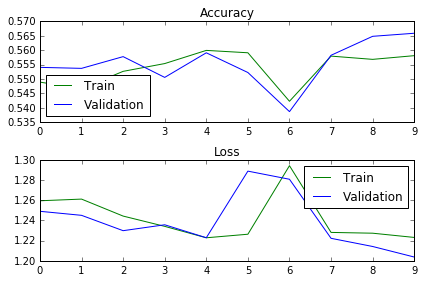

In [86]:
%matplotlib inline
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## GRU

In [79]:
NUM_EPOCHS = 10
NUM_ITERATIONS = 7


In [80]:
def build_pos_tagger_GRU():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(GRU(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(GRU(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [81]:
train_gen = generate_batch(ca_sents_word, s_word2index, ca_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(catest_sents_word, s_word2index, catest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [82]:
ca_sents_word, ca_w_freqs, ca_sents_pos, ca_pos_freqs = parse_file(ca_train)
catest_sents_word, catest_w_freqs, catest_sents_pos, catest_pos_freqs = parse_file(ca_test)

In [83]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [84]:
GRU_POS_TAGGER = build_pos_tagger_GRU()

In [85]:
for i in range(NUM_ITERATIONS):    
    history = GRU_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = GRU_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/10
28/28 [==============================] - 21s 767ms/step - loss: 2.4163 - acc: 0.3934 - val_loss: 2.1178 - val_acc: 0.4039
Epoch 2/10
28/28 [==============================] - 10s 350ms/step - loss: 2.0250 - acc: 0.4089 - val_loss: 1.8920 - val_acc: 0.4552
Epoch 3/10
28/28 [==============================] - 10s 348ms/step - loss: 1.7639 - acc: 0.4598 - val_loss: 1.6213 - val_acc: 0.4949
Epoch 4/10
28/28 [==============================] - 10s 350ms/step - loss: 1.5914 - acc: 0.4881 - val_loss: 1.5070 - val_acc: 0.5003
Epoch 5/10
28/28 [==============================] - 10s 353ms/step - loss: 1.4954 - acc: 0.5007 - val_loss: 1.5028 - val_acc: 0.4972
Epoch 6/10
28/28 [==============================] - 10s 357ms/step - loss: 1.4855 - acc: 0.5013 - val_loss: 1.4713 - val_acc: 0.5114
Epoch 7/10
28/28 [==============================] - 10s 350ms/step - loss: 1.4461 - acc: 0.5101 - val_loss: 1.4337 - val_acc: 0.5101
Epoch 8/10
28/28 [==============================] - 10s 353ms/step - 

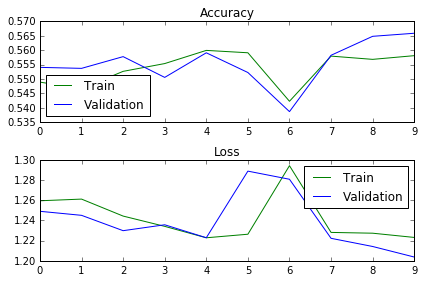

In [87]:
%matplotlib inline
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## LSTM

In [88]:
NUM_EPOCHS = 10
NUM_ITERATIONS = 8

In [89]:
def build_pos_tagger_LSTM():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(LSTM(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [90]:
LSTM_POS_TAGGER = build_pos_tagger_LSTM()

In [91]:
train_gen = generate_batch(ca_sents_word, s_word2index, ca_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(catest_sents_word, s_word2index, catest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [92]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []


In [93]:
for i in range(NUM_ITERATIONS):    
    history = LSTM_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = LSTM_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/10
28/28 [==============================] - 26s 941ms/step - loss: 2.3477 - acc: 0.4001 - val_loss: 1.9136 - val_acc: 0.4493
Epoch 2/10
28/28 [==============================] - 12s 440ms/step - loss: 1.7732 - acc: 0.4627 - val_loss: 1.6141 - val_acc: 0.4854
Epoch 3/10
28/28 [==============================] - 12s 428ms/step - loss: 1.5595 - acc: 0.4945 - val_loss: 1.5450 - val_acc: 0.4976
Epoch 4/10
28/28 [==============================] - 13s 461ms/step - loss: 1.4997 - acc: 0.5005 - val_loss: 1.4682 - val_acc: 0.5040
Epoch 5/10
28/28 [==============================] - 14s 484ms/step - loss: 1.4643 - acc: 0.5056 - val_loss: 1.5237 - val_acc: 0.4949
Epoch 6/10
28/28 [==============================] - 13s 478ms/step - loss: 1.4632 - acc: 0.5059 - val_loss: 1.4464 - val_acc: 0.5075
Epoch 7/10
28/28 [==============================] - 13s 472ms/step - loss: 1.4526 - acc: 0.5079 - val_loss: 1.4411 - val_acc: 0.5071
Epoch 8/10
28/28 [==============================] - 12s 428ms/step - 

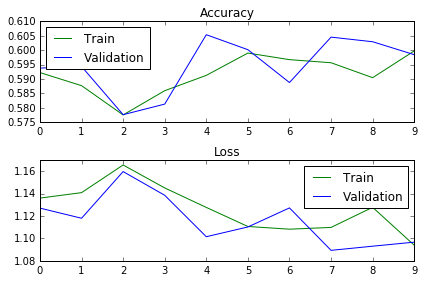

In [94]:
%matplotlib inline 
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Bidirectional LSTM

In [95]:
NUM_EPOCHS = 10
NUM_ITERATIONS = 8

In [96]:
def build_pos_tagger_Bidirectional():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(Bidirectional(LSTM(HIDDEN_SIZE))) 
    model.add(RepeatVector(MAX_SEQLEN)) 
    model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))) 
    model.add(TimeDistributed(Dense(t_vocabsize))) 
    model.add(Activation("softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

In [97]:
train_gen = generate_batch(ca_sents_word, s_word2index, ca_sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(catest_sents_word, s_word2index, catest_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [98]:
ca_sents_word, ca_w_freqs, ca_sents_pos, ca_pos_freqs = parse_file(ca_train)
catest_sents_word, catest_w_freqs, catest_sents_pos, catest_pos_freqs = parse_file(ca_test)

In [99]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [100]:
Bidirectional_POS_TAGGER = build_pos_tagger_Bidirectional()

In [101]:
for i in range(NUM_ITERATIONS):    
    history = Bidirectional_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = Bidirectional_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/10
28/28 [==============================] - 45s 2s/step - loss: 2.1411 - acc: 0.4083 - val_loss: 1.7340 - val_acc: 0.4843
Epoch 2/10
28/28 [==============================] - 26s 938ms/step - loss: 1.5514 - acc: 0.4954 - val_loss: 1.4750 - val_acc: 0.5106
Epoch 3/10
28/28 [==============================] - 27s 976ms/step - loss: 1.4670 - acc: 0.5109 - val_loss: 1.4502 - val_acc: 0.5084
Epoch 4/10
28/28 [==============================] - 27s 974ms/step - loss: 1.4468 - acc: 0.5191 - val_loss: 1.4358 - val_acc: 0.5228
Epoch 5/10
28/28 [==============================] - 28s 1s/step - loss: 1.4195 - acc: 0.5243 - val_loss: 1.3850 - val_acc: 0.5280
Epoch 6/10
28/28 [==============================] - 29s 1s/step - loss: 1.4131 - acc: 0.5227 - val_loss: 1.3867 - val_acc: 0.5359
Epoch 7/10
28/28 [==============================] - 29s 1s/step - loss: 1.3865 - acc: 0.5292 - val_loss: 1.3753 - val_acc: 0.5315
Epoch 8/10
28/28 [==============================] - 29s 1s/step - loss: 1.3671 - 

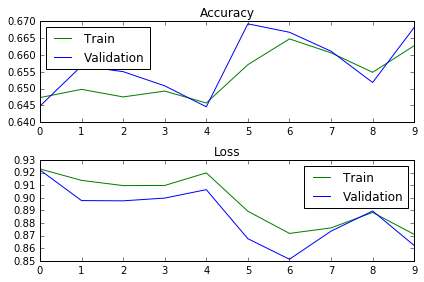

In [102]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Результаты

#### Для каждой сети было подобрано оптимальное количество эпох и итераций.
#### Наилучшим образом зарекомендовала себя сеть Bidirectional LSTM, с точностью 0.66, а наихудшим - GRU, с точностью 0,56. Это можно объяснить тем, что для Bidirectional LSTM характерно использование контекста для предсказания.